In [1]:
import datetime
import gc
import json
import os
import matplotlib.dates as md
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)

def safe_map(x):
    """Map known addresses to owners"""
    try: return known_addresses[x]
    except: return x

# known addresses
# Mix of whaleAPI labels and manual labels
with open("data/known_addresses.json", 'r') as f:
    known_addresses = json.load(f)
    
### Read & Clean ETH blockchain data
# From https://etherscan.io/address/0x5754284f345afc66a98fbb0a0afe71e0f007b949#tokentxns
eth = pd.read_csv("eth.csv", index_col=False)
eth['date'] = pd.to_datetime(eth.DateTime)
eth = eth.drop(columns=['DateTime', 'Txhash', 'UnixTimestamp', 'ContractAddress', 'TokenName'])
eth.columns = ['from', 'to', 'value', 'token', 'date']
eth['chain'] = 'eth'
eth = eth[['date', 'value', 'token', 'from', 'to', 'chain']]
eth.to = eth.to.apply(safe_map)
eth['from'] = eth['from'].apply(safe_map)

### Read & Clean Tron blockchain data
# From https://tronscan.org/#/address/TKHuVq1oKVruCGLvqVexFs6dawKv6fQgFs/transfers
tron = pd.read_csv("tron.csv")
tron = tron.drop(columns=['transaction_id', 'block', 'contractRet', 'confirmed'])
tron.columns = ['date', 'from', 'to', 'value']
tron['chain'] = 'tron'
tron['token'] = 'USDT'
tron = tron[['date', 'value', 'token', 'from', 'to', 'chain']]
tron['date'] = pd.to_datetime(tron.date)
tron.to = tron.to.apply(safe_map)
tron['from'] = tron['from'].apply(safe_map)

### Unify dataset
df = (
    pd.concat([eth, tron])
      .sort_values(by='date')
      .reset_index(drop=True)
)
# Fix numeric values
df.value = pd.to_numeric(
    df.value.astype(str)
      .str.replace(",", "")
)
# Money coming back to treasury is a negative tx
df['direction'] = (df['from'] == 'tether scrambler tron').map({True: 'out', False: 'in'})
df.loc[
    ((df.to.str.contains('tether'))
    & ~(df['from'].str.contains('mint'))
    & ~(df['from'].str.contains('cold'))
    )
    | (df.direction == 'in')
    , 'value'] *= -1
# Remove $1B chain swap
df = df.loc[
    ~(
        (df.date.dt.date == '2021-05-19')
        & (df.value.abs() > 498_000_000)
    )
]
df

,date,value,token,from,to,chain,direction
0,2020-01-01 08:19:32,-144000.00,USDT,tether scrambler eth,0x3ad8ed749d1fef1192f3e78610316728d5edc961,eth,in
1,2020-01-01 08:20:36,-2000000.00,USDT,tether scrambler eth,0x2acc996ba2667ae6455fdd572f3b06510a2305ba,eth,in
2,2020-01-02 09:21:57,-50000.00,USDT,tether scrambler eth,wallet 6 (stablecoin trader),eth,in
3,2020-01-03 07:02:11,-0.01,USDT,wallet 2 (ping tx),tether scrambler eth,eth,in
4,2020-01-03 17:19:28,-7099615.38,USDT,tether scrambler eth,0x0c7719f1d7ed41271cbba92ec153afa6610228f8,eth,in
...,...,...,...,...,...,...,...
4870,2021-07-12 16:45:32,-20000000.00,USDT,0xb60c61dbb7456f024f9338c739b02be68e3f545c,tether scrambler eth,eth,in
4871,2021-07-13 12:11:06,-20000000.00,USDT,0xb60c61dbb7456f024f9338c739b02be68e3f545c,tether scrambler eth,eth,in
4872,2021-07-13 14:18:26,-80000000.00,USDT,0x41318419cfa25396b47a94896ffa2c77c6434040,tether scrambler eth,eth,in
4873,2021-07-14 08:42:51,825933.13,USDT,tether scrambler tron,TXM6v6SqM99JRYjkH3X4PDmCtiRbok1CJu,tron,out


In [2]:
df['day'] = df.date.dt.date
tt = df.loc[~df['from'].str.contains('cold') & ~df['from'].str.contains('mint')].copy()
# Remove Chain Swap
tt = tt.loc[np.abs(tt.value) < 900_000_000]
tt = tt.groupby(['day', 'direction']).sum().reset_index()
tt['date'] = tt.day
tt = tt[['date', 'direction', 'value']]
tt.head(3)

,date,direction,value
0,2020-01-01,in,-2144000.00
1,2020-01-02,in,-50000.00
2,2020-01-03,in,-22099615.39


In [3]:
# Remove chain swap
tt = tt.loc[tt.date.astype(str) != '2021-02-03']

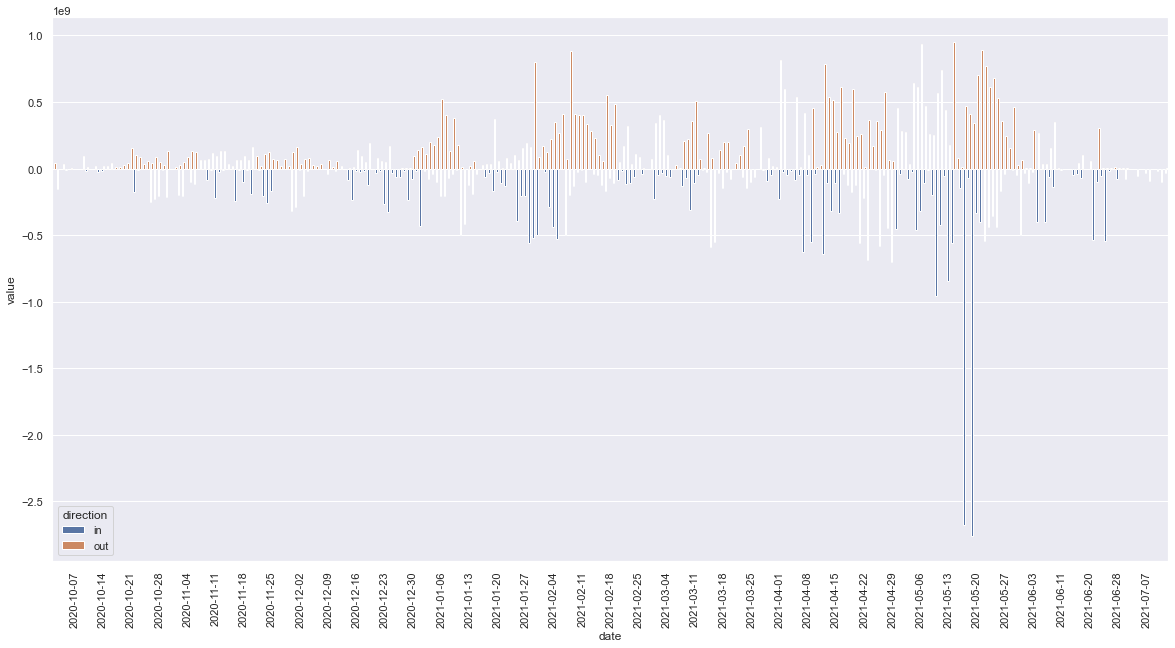

In [4]:
fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(
    data=tt.loc[pd.to_datetime(tt.date) > '2020-10-01'],
    x="date", y='value', 
    hue="direction",
    ax=ax
)
ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday=1, interval=1))
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 90)
plt.show()

In [8]:
df.head()

,date,value,token,from,to,chain,direction,day
0,2020-01-01 08:19:32,-144000.00,USDT,tether scrambler eth,0x3ad8ed749d1fef1192f3e78610316728d5edc961,eth,in,2020-01-01
1,2020-01-01 08:20:36,-2000000.00,USDT,tether scrambler eth,0x2acc996ba2667ae6455fdd572f3b06510a2305ba,eth,in,2020-01-01
2,2020-01-02 09:21:57,-50000.00,USDT,tether scrambler eth,wallet 6 (stablecoin trader),eth,in,2020-01-02
3,2020-01-03 07:02:11,-0.01,USDT,wallet 2 (ping tx),tether scrambler eth,eth,in,2020-01-03
4,2020-01-03 17:19:28,-7099615.38,USDT,tether scrambler eth,0x0c7719f1d7ed41271cbba92ec153afa6610228f8,eth,in,2020-01-03


In [11]:
df['day'] = df.date.dt.date
tt = df.loc[~df['from'].str.contains('cold') & ~df['from'].str.contains('mint')].copy()
# Remove Chain Swap
tt = tt.loc[np.abs(tt.value) < 900_000_000]
tt = tt.groupby(['day', 'direction', 'from']).sum().reset_index()
tt['date'] = tt.day
tt = tt[['date', 'direction', 'value', 'from']]

# Remove chain swap
tt = tt.loc[tt.date.astype(str) != '2021-02-03']

tt.head(3)

,date,direction,value,from
0,2020-01-01,in,-2144000.00,tether scrambler eth
1,2020-01-02,in,-50000.00,tether scrambler eth
2,2020-01-03,in,-7099615.38,tether scrambler eth


In [21]:
tt.loc[pd.to_datetime(tt.date) > '2021-06-01'].groupby('from').value.sum().sort_values()

from
tether scrambler eth                         -8.604826e+08
bitfinex (tron)                              -8.562914e+08
0xb60c61dbb7456f024f9338c739b02be68e3f545c   -5.743475e+08
0x41318419cfa25396b47a94896ffa2c77c6434040   -2.601200e+08
0xca9ac16b08e6aa1dac2c83fea1dddbd46c6e38d1   -1.500000e+08
0x29146557ce37eaf8090a4300b5083a40ef28687b   -1.100000e+08
0xf36a47300f002c0c9f8c131962f077c3543b2fc6   -8.000000e+07
bitfinex                                     -4.000000e+07
0xa910f92acdaf488fa6ef02174fb86208ad7722ba   -4.000000e+07
TD8mvHVhMKX2wCgbPwZehWAk6wEvNtHcgL           -2.950000e+07
TN5rNoA4ZibQS15LxVptSgwwztXqfB6jgd           -2.515000e+07
0xe11970f2f3de9d637fb786f2d869f8fea44195ac   -1.800000e+07
0x1b705bec5ca8406fd621ef09010a4c3a233e19eb   -1.450000e+07
wallet 4 (large trader)                      -1.000000e+07
TTGyhRZxZRcDz4M1bBwrsiKkZNS2GRYfWn           -7.350903e+06
0x7c04a698855d1ecf9610636a1d7aff8e03331fa5   -7.000000e+06
0xf0c5c1fdd41fbe4c90784df15e5120cae8e26bf9   -1.860

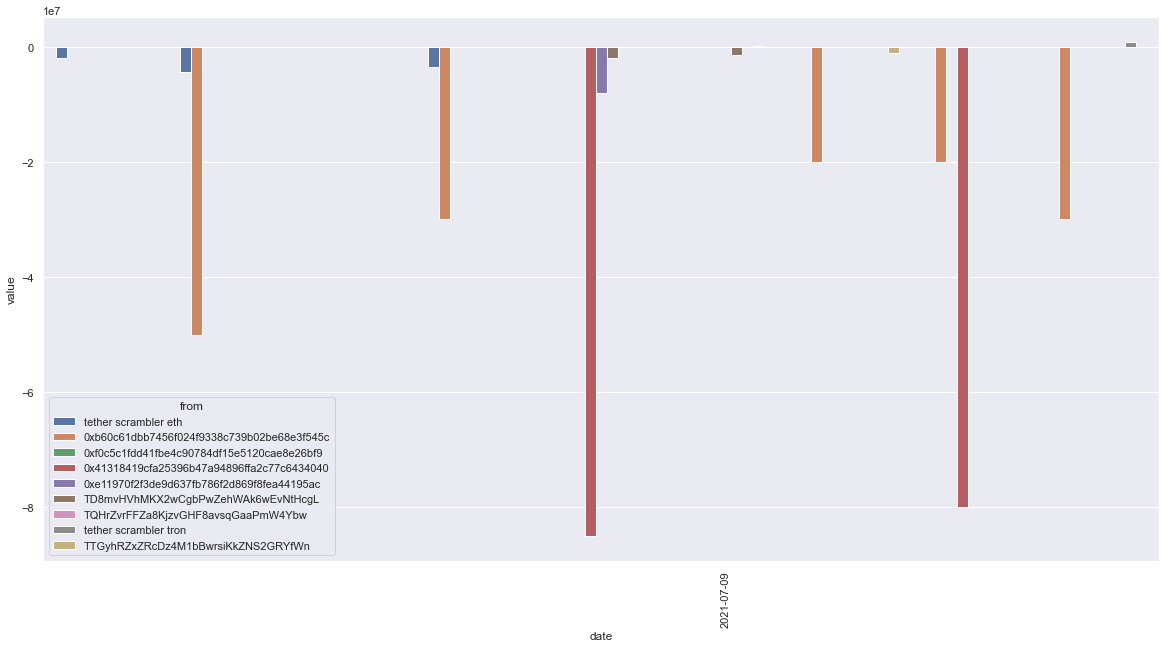

In [15]:
fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(
    data=tt.loc[pd.to_datetime(tt.date) > '2021-07-01'],
    x="date", y='value', 
    hue="from",
    ax=ax
)
ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday=1, interval=1))
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 90)
plt.show()

In [5]:
df.loc[(df.direction == 'in') & (df.date >= '2021-05-15')].sort_values(by='value')

,date,value,token,from,to,chain,direction,day
4409,2021-05-17 15:39:48,-1.000000e+09,USDT,bitfinex (mint),tether scrambler eth,eth,in,2021-05-17
4620,2021-05-24 17:50:30,-1.000000e+09,USDT,TBPxhVAsuzoFnKyXtc1o2UySEydPHgATto,tether scrambler tron,tron,in,2021-05-24
4570,2021-05-22 10:18:03,-1.000000e+09,USDT,TBPxhVAsuzoFnKyXtc1o2UySEydPHgATto,tether scrambler tron,tron,in,2021-05-22
4707,2021-05-31 15:09:40,-1.000000e+09,USDT,bitfinex (mint),tether scrambler eth,eth,in,2021-05-31
4677,2021-05-28 13:04:24,-1.000000e+09,USDT,TBPxhVAsuzoFnKyXtc1o2UySEydPHgATto,tether scrambler tron,tron,in,2021-05-28
4708,2021-05-31 15:12:53,-1.000000e+09,USDT,tether scrambler eth,binance,eth,in,2021-05-31
4705,2021-05-31 15:02:24,-1.000000e+09,USDT,binance,tether scrambler tron,tron,in,2021-05-31
4704,2021-05-31 14:52:57,-1.000000e+09,USDT,tether scrambler eth,binance,eth,in,2021-05-31
4703,2021-05-31 14:49:22,-1.000000e+09,USDT,bitfinex (mint),tether scrambler eth,eth,in,2021-05-31
4702,2021-05-31 14:43:18,-1.000000e+09,USDT,binance,tether scrambler tron,tron,in,2021-05-31
